In [ ]:
#| default_exp core.schedule

In [ ]:
#| export
import numpy as np
import matplotlib.pyplot as plt
from fastcore.basics import *
from fastai.callback.schedule import *
import math
from typing import Union, Callable, Optional, Any

In [ ]:
#| include: false
from fastai.vision.all import *
from nbdev.showdoc import *
%config InlineBackend.figure_format = 'retina'

In [ ]:
#| export
class Schedule():
    "Base class to create schedules"
    def __init__(self, 
                 sched_func: Callable,      # Function that computes sparsity at given training percentage
                 start_pct: float = 0.,     # Percentage of training to start pruning
                 end_pct: float = 1.,       # Percentage of training to end pruning (default: 1.0)
                 start_sparsity: float = 0. # Initial sparsity level
    ):
        "Base class to create sparsity schedules for pruning"
        store_attr()
        self.current_sparsity, self.previous_sparsity = map(listify, [start_sparsity, start_sparsity])
        
    def __call__(self, 
                 end_sparsity: Union[float, list[float]], # Target sparsity level(s)
                 pct_train: float                         # Current percentage of training complete
    ) -> list[float]:
        "Calculate current sparsity level based on training progress"
        end_sparsity_list = listify(end_sparsity)
        if pct_train >= self.start_pct and pct_train <= self.end_pct:
            normalized_pct = (pct_train - self.start_pct) / (self.end_pct - self.start_pct)
            self.current_sparsity = [self.sched_func(self.start_sparsity, sp, normalized_pct) for sp in end_sparsity_list]
        return self.current_sparsity
        
    @property
    def pruned(self) -> bool:
        "Check if sparsity level has changed since last update"
        return self.previous_sparsity!=self.current_sparsity
    
    def after_pruned(self) -> None:
        "Update previous sparsity after pruning is applied"
        self.previous_sparsity=self.current_sparsity
    
    def plot(self, 
             end_sparsity: float,     # Target sparsity to visualize 
             num_points: int = 1000  # Target sparsity to visualize 
    ) -> None:
        "Plot the sparsity schedule"
        prune = np.linspace(0, 1, num_points)
        sps = [self([end_sparsity], p) for p in prune]
        fig, ax = plt.subplots(1, 1, figsize=(8,6), dpi=100)
        plt.plot(prune, sps, c='teal', linewidth=2)
        plt.xlabel('training iterations (Normalized)')
        plt.ylabel('sparsity')
        self.current_sparsity = self.previous_sparsity
    
    def reset(self) -> None:
        "Reset schedule to initial state"
        self.current_sparsity, self.previous_sparsity = map(listify, [self.start_sparsity, self.start_sparsity])

    
    def _scheduler(self, pruning_ratio_dict, steps, start=0, end=1, *args, **kwargs):
        return [
            self.sched_func(start, end, i / float(steps), *args, **kwargs) * pruning_ratio_dict
            for i in range(steps + 1)
        ]

In [ ]:
show_doc(Schedule)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L15){target="_blank" style="float:right; font-size:smaller"}

### Schedule

>      Schedule (sched_func:Callable, start_pct:float=0.0, end_pct:float=1.0,
>                start_sparsity:float=0.0)

*Base class to create schedules*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| sched_func | Callable |  | Function that computes sparsity at given training percentage |
| start_pct | float | 0.0 | Percentage of training to start pruning |
| end_pct | float | 1.0 | Percentage of training to end pruning (default: 1.0) |
| start_sparsity | float | 0.0 | Initial sparsity level |

The `Schedule` class allows you to create any schedule function according to 4 parameters: <br>
- the `sched_func`: the function according to which the sparsity will evolve (e.g. linear, cos, ...) <br>
- the `start_pct`: the percentage of training steps at which the sparsification process will start <br>
- the `end_pct`: the percentage of training steps at which the sparsification process will end <br>
- the `start_sparsity`: the percentage of sparsity at which the model starts 

## One-Shot

The easiest schedule is the one-shot pruning, i.e. prune the network once. This can be done by simply returning the desired sparsity value. The moment when you want to prune will be controlled by the `start_epoch` argument in the `SparsifyCallback`.

In [ ]:
#| export
def sched_oneshot(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "One-shot pruning: jump directly to target sparsity"
    return end

one_shot = Schedule(sched_oneshot, start_pct=0.5)

In [ ]:
show_doc(sched_oneshot)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L55){target="_blank" style="float:right; font-size:smaller"}

### sched_oneshot

>      sched_oneshot (start:float, end:float, pos:float)

*One-shot pruning: jump directly to target sparsity*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| start | float | Starting sparsity level |
| end | float | Target sparsity level |
| pos | float | Current position in schedule (0-1) |
| **Returns** | **float** |  |

In [ ]:
one_shot.plot(50)

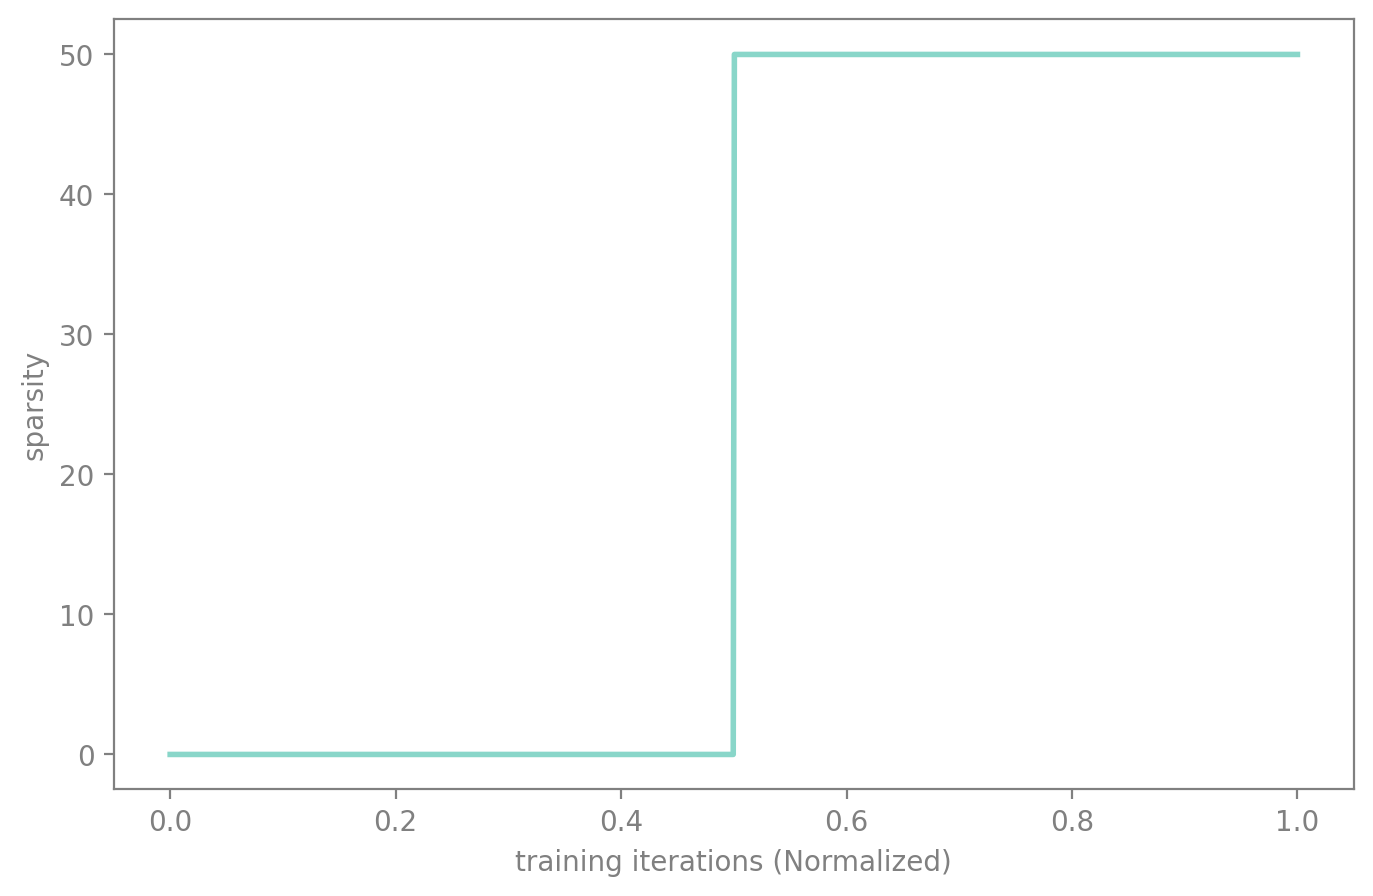

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [one_shot([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Iterative

Instead of pruning the network to desired sparsity in one step, you can do it iteratively. In fasterai, you can change the amount of iterations

In [ ]:
#| export
def sched_iterative(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float,   # Current position in schedule (0-1)
    n_steps: int = 3  # Number of pruning steps
) -> float:
    "Perform iterative pruning in discrete steps"
    return start + ((end-start)/n_steps) * (np.ceil(pos * n_steps))

iterative = Schedule(sched_iterative, start_pct=0.2)

In [ ]:
show_doc(sched_iterative)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L60){target="_blank" style="float:right; font-size:smaller"}

### sched_iterative

>      sched_iterative (start:float, end:float, pos:float, n_steps:int=3)

*Perform iterative pruning in discrete steps*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| start | float |  | Starting sparsity level |
| end | float |  | Target sparsity level |
| pos | float |  | Current position in schedule (0-1) |
| n_steps | int | 3 | Number of pruning steps |
| **Returns** | **float** |  |  |

In [ ]:
iterative.plot(50)

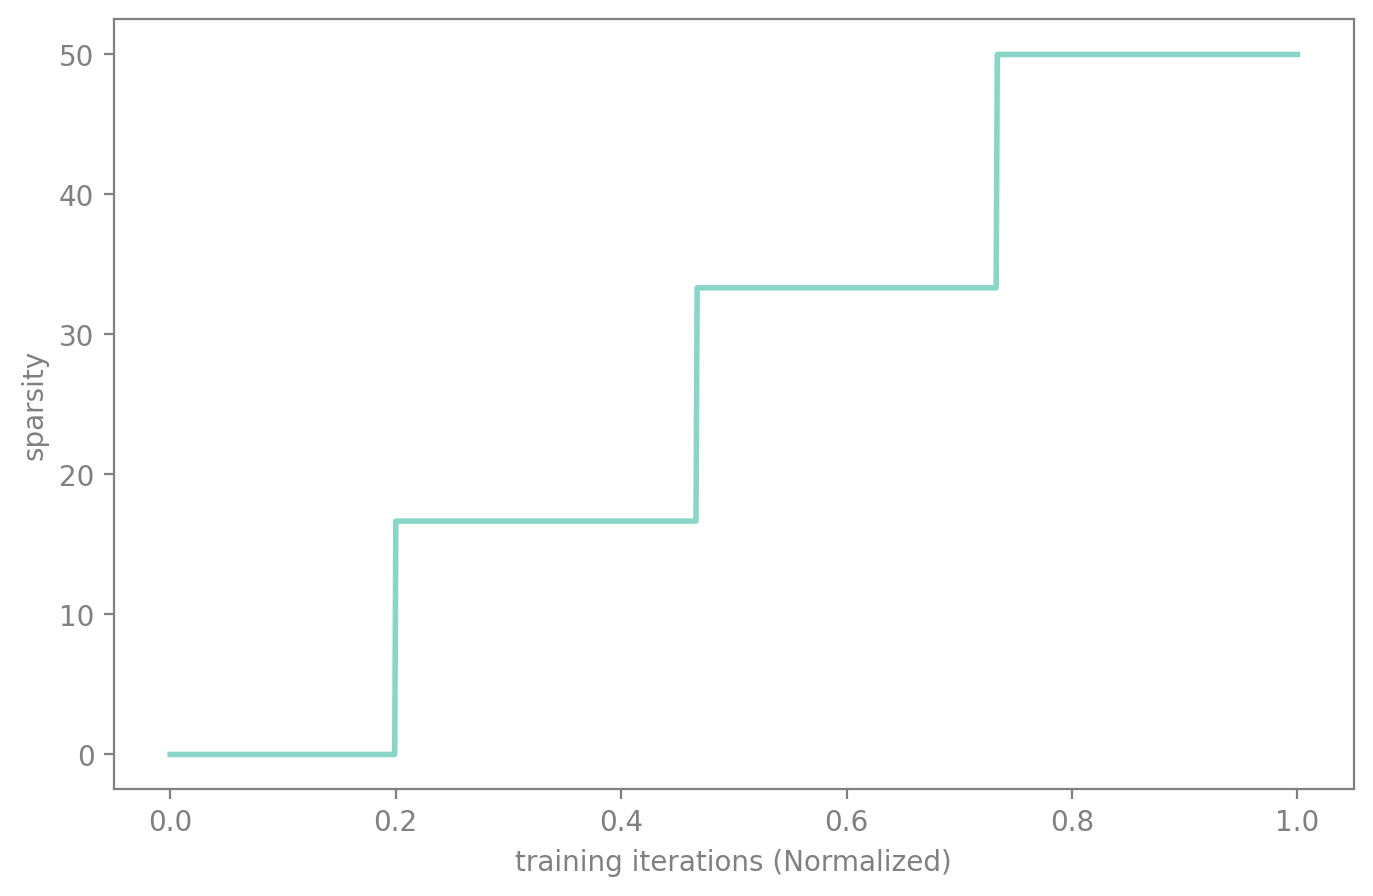

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [iterative([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

To modify the default `n_steps`, you can use the `partial` function.

In [ ]:
iterative = Schedule(partial(sched_iterative, n_steps=5), start_pct=0.2)

In [ ]:
iterative.plot(50)

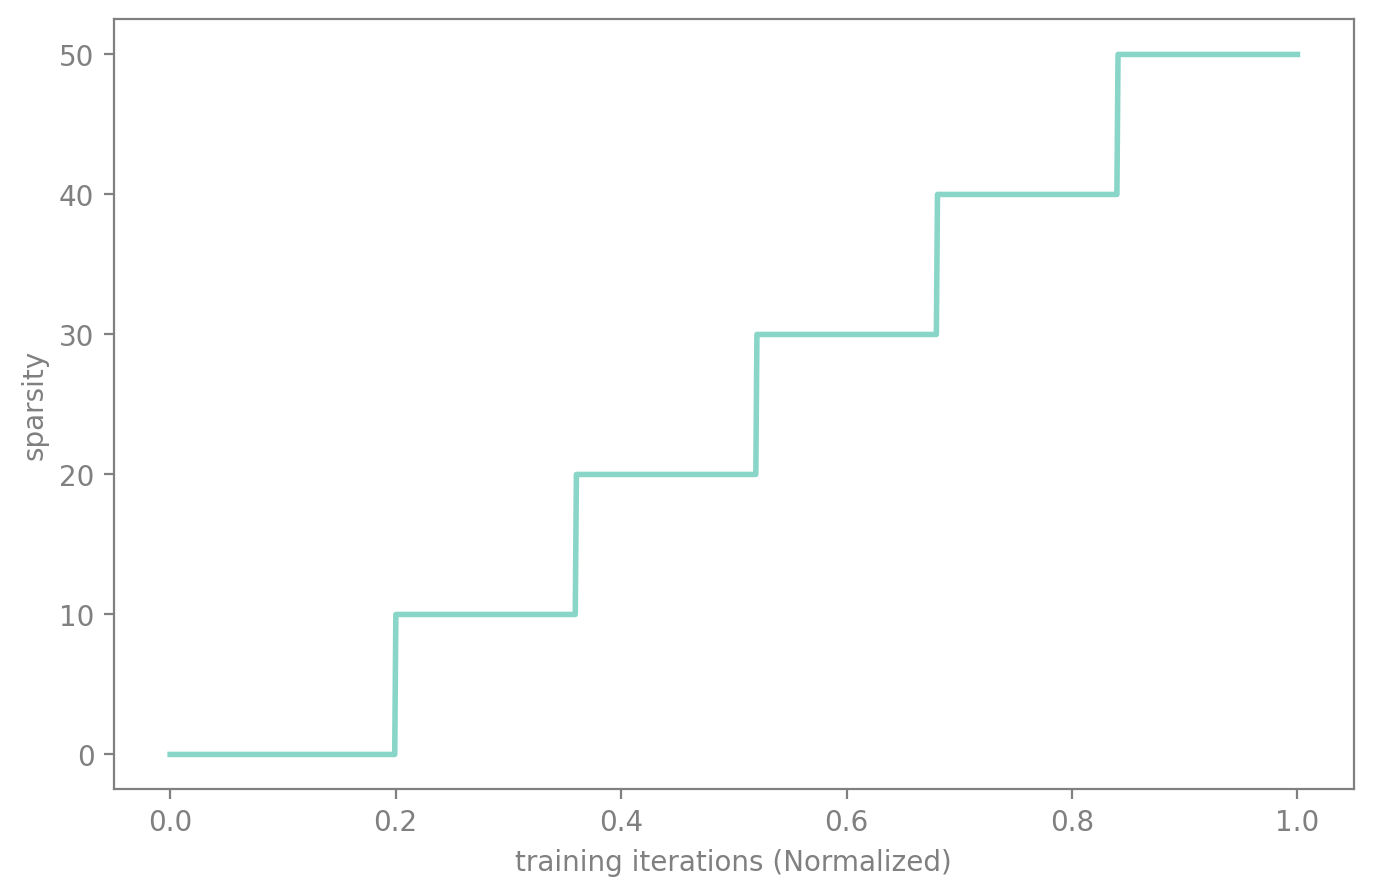

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [iterative([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Automated Gradual Pruning

Some researchers have come up with more sophisticated schedules, such as the [Automated Gradual Pruning](https://arxiv.org/abs/1710.01878).

In [ ]:
#| export
def sched_agp(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "Automated gradual pruning schedule with cubic decay"
    return end + (start - end) * (1 - pos)**3

agp = Schedule(sched_agp, start_pct=0.2)

In [ ]:
show_doc(sched_agp)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L67){target="_blank" style="float:right; font-size:smaller"}

### sched_agp

>      sched_agp (start:float, end:float, pos:float)

*Automated gradual pruning schedule with cubic decay*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| start | float | Starting sparsity level |
| end | float | Target sparsity level |
| pos | float | Current position in schedule (0-1) |
| **Returns** | **float** |  |

In [ ]:
agp.plot(50)

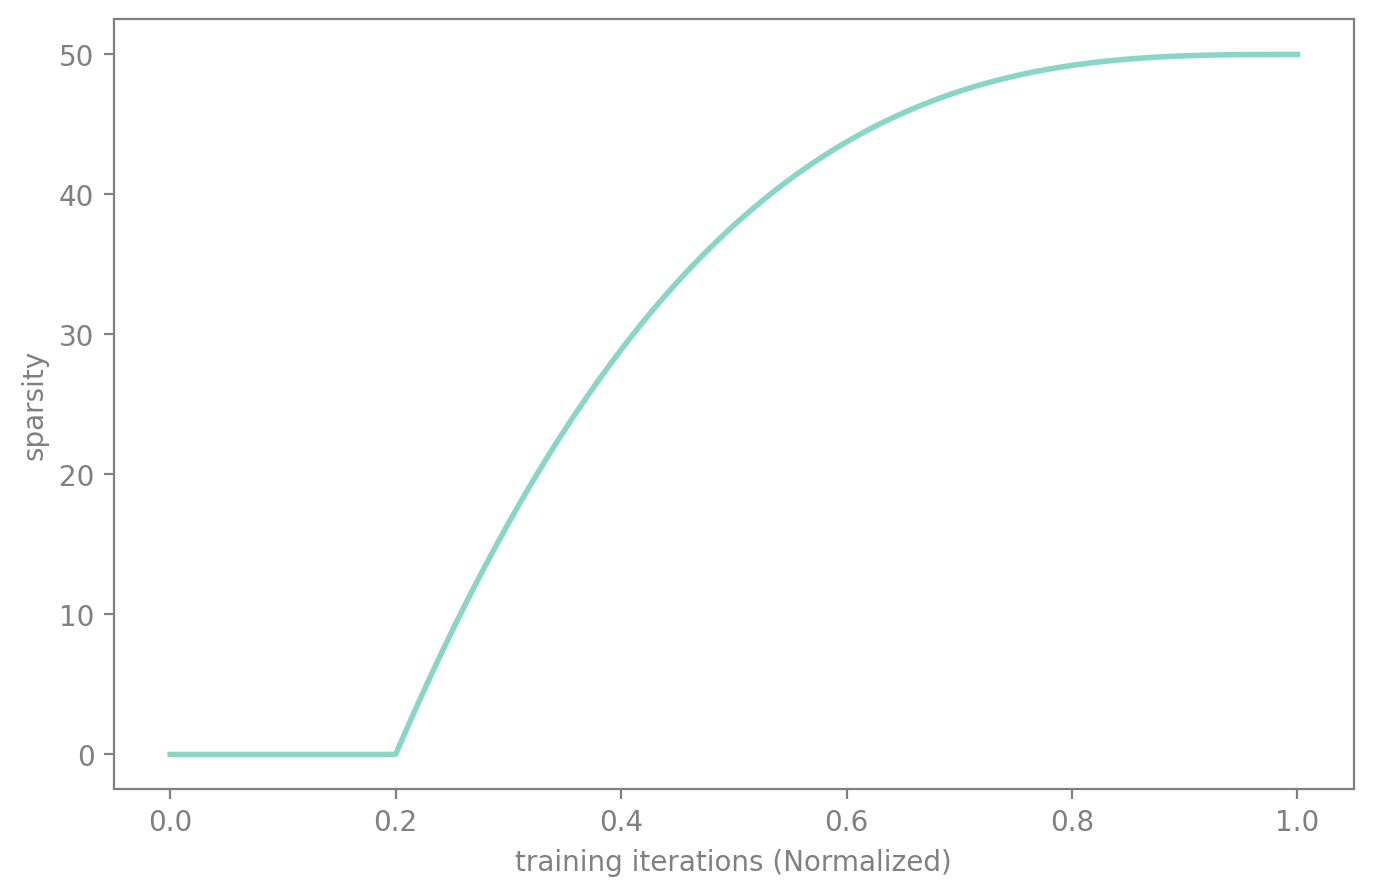

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [agp([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

## One-Cycle Pruning

In [ ]:
#| export
def sched_onecycle(
    start: float,  # Starting sparsity level
    end: float,    # Target sparsity level
    pos: float,    # Current position in schedule (0-1)
    α: float = 14, # Steepness parameter
    β: float = 6   # Offset parameter
) -> float:
    "One-cycle schedule based on logistic function"
    out = (1+np.exp(-α+β)) / (1 + (np.exp((-α*pos)+β)))
    return start + (end-start)*out

one_cycle = Schedule(sched_onecycle)

In [ ]:
show_doc(sched_onecycle)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L72){target="_blank" style="float:right; font-size:smaller"}

### sched_onecycle

>      sched_onecycle (start:float, end:float, pos:float, α:float=14, β:float=6)

*One-cycle schedule based on logistic function*

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| start | float |  | Starting sparsity level |
| end | float |  | Target sparsity level |
| pos | float |  | Current position in schedule (0-1) |
| α | float | 14 | Steepness parameter |
| β | float | 6 | Offset parameter |
| **Returns** | **float** |  |  |

In [ ]:
one_cycle.plot(50)

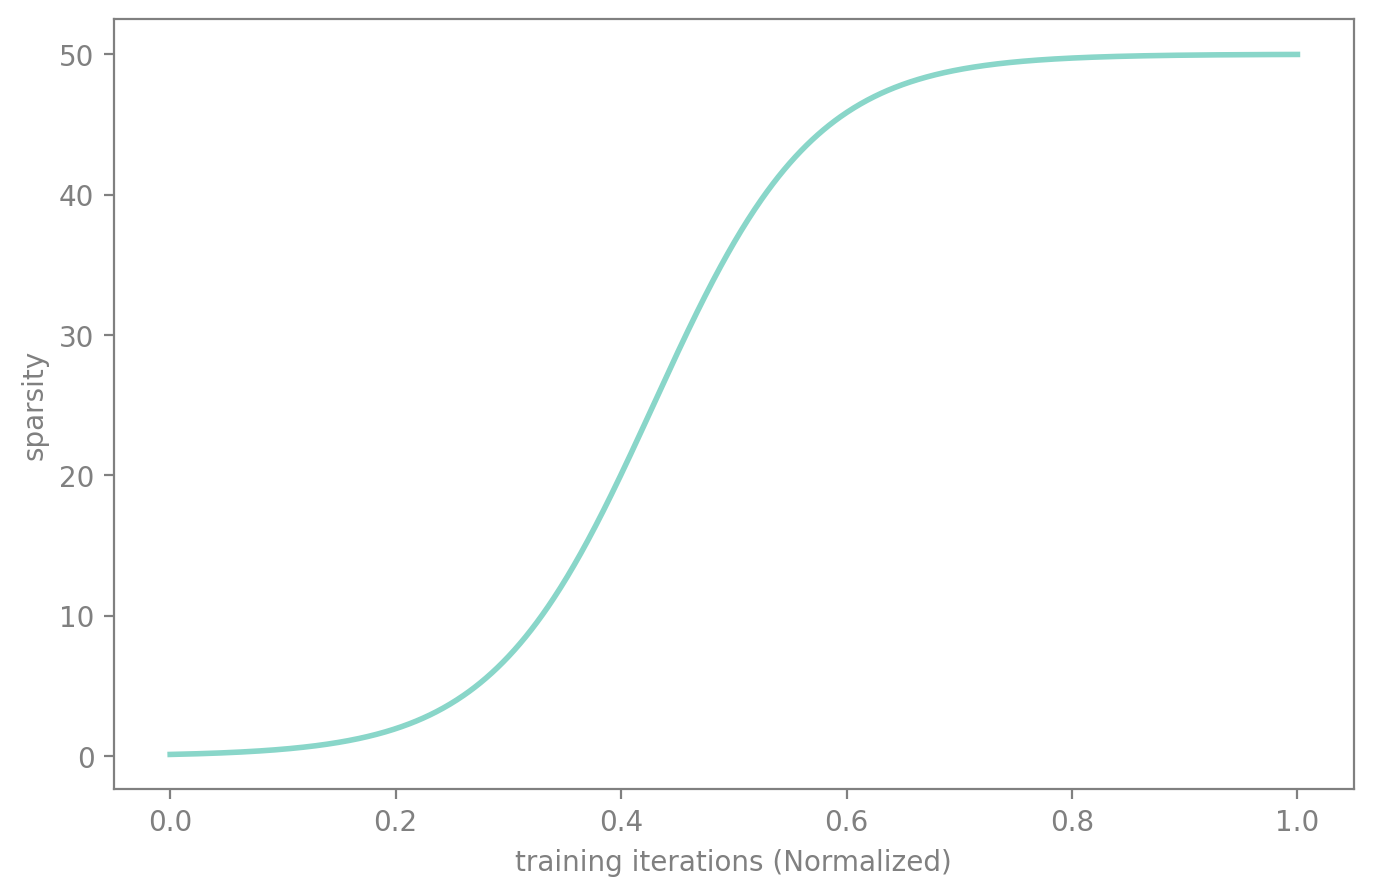

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [one_cycle([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

On top of that, all of the schedules available in fastai by default are also available:
- sched_cos
- sched_linear

In [ ]:
#| export
cos = Schedule(sched_cos)
lin = Schedule(sched_lin)

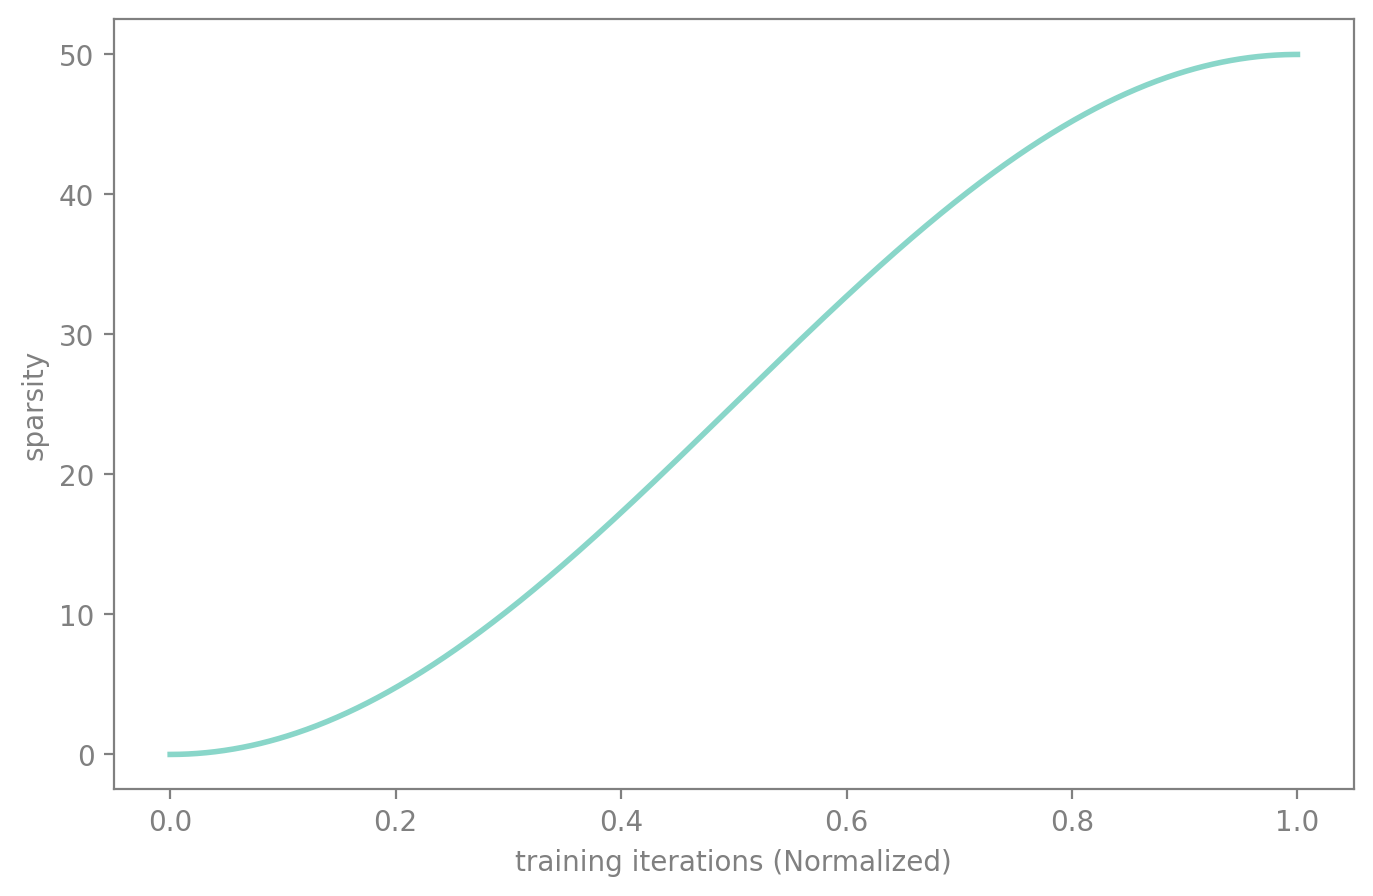

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [cos([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

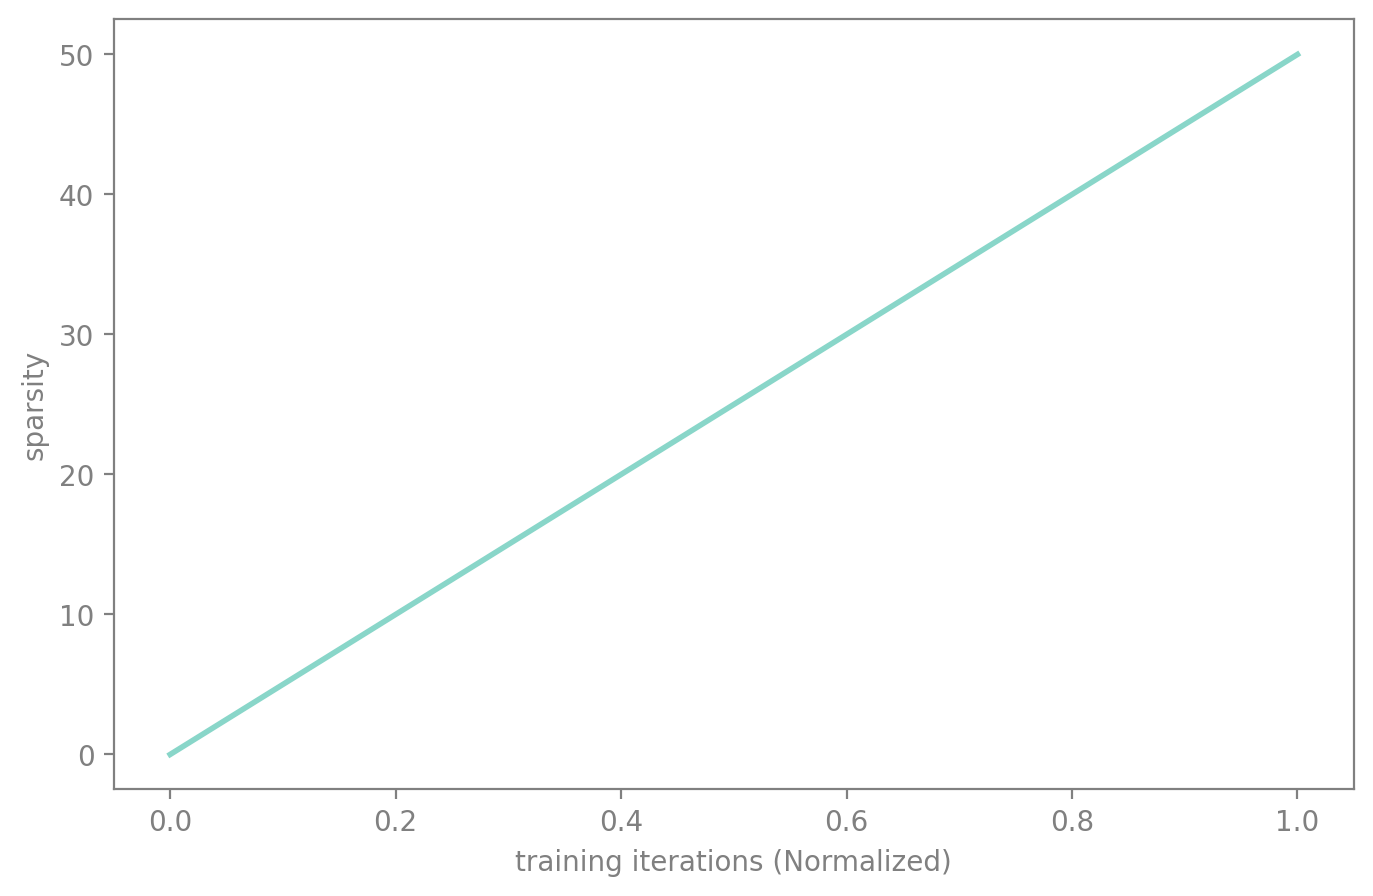

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [lin([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

---

## Dense-Sparse-Dense

You can also create even more interesting behaviours such as the DSD method, where you prune the model in the first place, then re-grow it to its initial amount of parameter.

In [ ]:
#| export
def sched_dsd(
    start: float, # Starting sparsity level
    end: float,   # Target sparsity level
    pos: float    # Current position in schedule (0-1)
) -> float:
    "Dense-Sparse-Dense schedule: increase then decrease sparsity"
    if pos<0.5:
        return start + (1 + math.cos(math.pi*(1-pos*2))) * (end-start) / 2
    else:
        return end + (1 - math.cos(math.pi*(1-pos*2))) * (start-end) / 2
    
dsd = Schedule(sched_dsd)

In [ ]:
show_doc(sched_dsd)

---

[source](https://github.com/FasterAI-Labs/fasterai/tree/master/blob/master/fasterai/core/schedule.py#L83){target="_blank" style="float:right; font-size:smaller"}

### sched_dsd

>      sched_dsd (start:float, end:float, pos:float)

*Dense-Sparse-Dense schedule: increase then decrease sparsity*

|    | **Type** | **Details** |
| -- | -------- | ----------- |
| start | float | Starting sparsity level |
| end | float | Target sparsity level |
| pos | float | Current position in schedule (0-1) |
| **Returns** | **float** |  |

In [ ]:
dsd.plot(50)

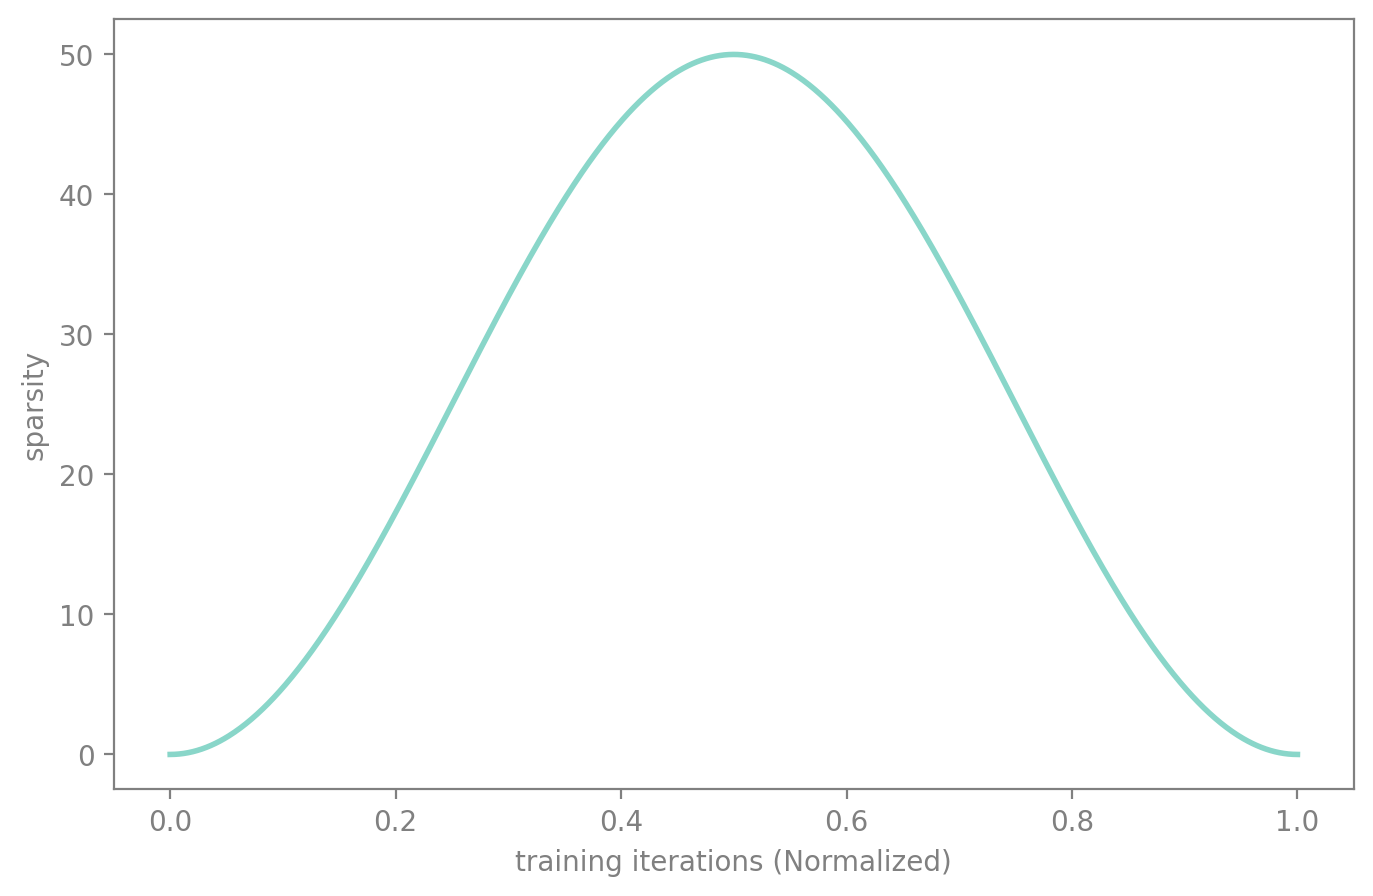

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)

prune = np.linspace(0, 1, 1000)
sps = [dsd([50], p) for p in prune]
plt.plot(prune, sps, c='#89d6c9', linewidth=2)
plt.xlabel('training iterations (Normalized)')
plt.ylabel('sparsity')

        
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')

In [ ]:
#| export
schedules = ('one_shot', 'iterative', 'agp', 'one_cycle', 'cos', 'lin', 'dsd')
def available_schedules() -> list[str]:
    "Return list of available pruning schedules"
    return list(schedules)